# DrChex
## An image classification model developed on top of pre-trained Resnet model for detecting **PNEUMONIA** in **Chest Xrays**.  

Pre-rquisit to run on your GDrive:
1. upload image folder in project folder in gdrive
2. modify pathes to the `project folder` and `xray images`

Data Source : [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)


In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 19.6MB/s 
     |████████████████████████████████| 1.2MB 48.4MB/s 
     |████████████████████████████████| 194kB 48.3MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
Mounted at /content/gdrive


In [146]:
import time
from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import *

In [3]:
# essential paths to project and data folders
project_path = Path('gdrive/MyDrive/Colab Notebooks/DrChex')
xrays_path = project_path/'chest_xray'

In [4]:
# check if any image is corrupt
start = time.time()
link2imgs = get_image_files(project_path/'chest_xray')
end = time.time()
print(f'elapsed time to link to all images : {end - start:0.2f}s')

start = time.time()
failed_imgs = verify_images(link2imgs)
end = time.time()
print(f'number of corrupt images : {failed_imgs}')
print(f'elapsed time to verify all images : {end - start:0.2f}s')

elapsed time to link to all images : 23.34s
number of corrupt images : []
elapsed time to verify all images : 577.53s


In [38]:
# build the data block wrapper
xrays = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(train_name='train', valid_name='test'),
    item_tfms=Resize(128))

In [39]:
# to load images and view few of them to see how they look
dls = xrays.dataloaders(xrays_path)

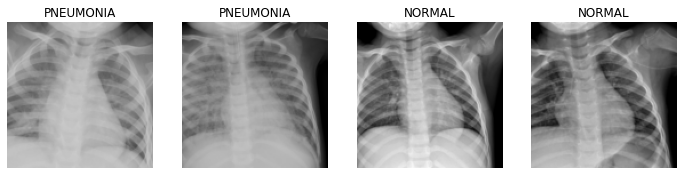

In [40]:
# viewing some images from validation set with Resize=(crop) transformer
dls.train.show_batch(max_n=4, nrows=1)

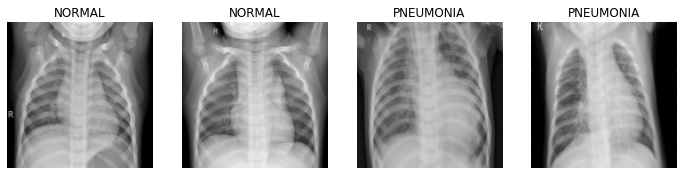

In [41]:
# viewing some images from validation set with Squish methode transformer
xrays = xrays.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = xrays.dataloaders(xrays_path)
dls.train.show_batch(max_n=4, nrows=1)

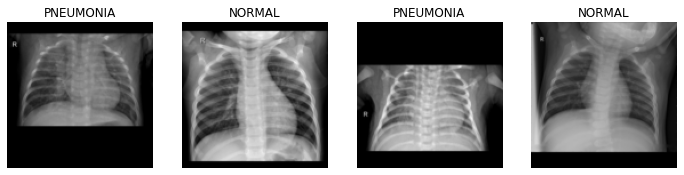

In [42]:
# viewing some images from validation set with Padding methode transformer
xrays = xrays.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = xrays.dataloaders(xrays_path)
dls.train.show_batch(max_n=4, nrows=1)

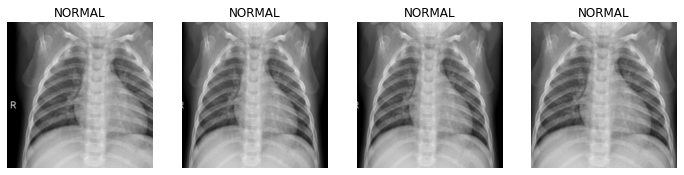

In [43]:
# viewing some images from validation set with RandomCrop methode transformer
xrays = xrays.new(item_tfms=RandomResizedCrop(224, min_scale=0.75))
dls = xrays.dataloaders(xrays_path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [47]:
# go with random crop and also an augmentation transformer
xrays = xrays.new(item_tfms=RandomResizedCrop(224, min_scale=0.5),
                  batch_tfms=aug_transforms())
dls = xrays.dataloaders(xrays_path)

In [48]:
# craete the CNN and train it on data
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.539693,0.365721,0.116987,01:29


epoch,train_loss,valid_loss,error_rate,time
0,0.265219,0.522074,0.145833,01:30
1,0.193046,0.335744,0.092949,01:29
2,0.151865,0.219713,0.067308,01:30
3,0.129134,0.210672,0.059295,01:30


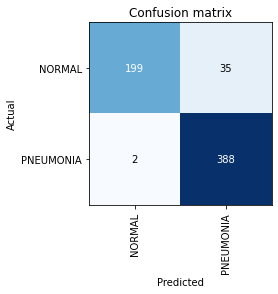

In [49]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

It has a very good `True Positive` rate (eg. correctly detecting xrays with `Pneumonia`, but struggling with low `False Positive` rate.

In [50]:
# save the model
#learn.export(project_path/'drchex_rrc_224_0.5_aug.pkl')

In [52]:
# Try another transformation setting if performance improves 
xrays = xrays.new(item_tfms=Rize(224, ResizeMethod.Squish))
dls = xrays.dataloaders(xrays_path)

learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.395988,0.757835,0.184295,01:37


epoch,train_loss,valid_loss,error_rate,time
0,0.125185,0.612027,0.134615,01:36
1,0.065980,0.984012,0.173077,01:35
2,0.026305,1.139605,0.216346,01:38
3,0.011341,0.926959,0.173077,01:37


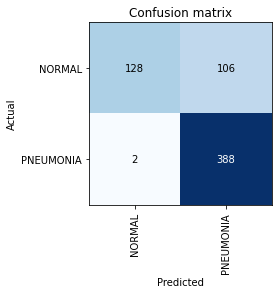

In [53]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [125]:
# more trial and error aiming better performance

xrays = xrays.new(item_tfms=RandomResizedCrop(224, min_scale=0.5))

dls = xrays.dataloaders(xrays_path)

learn = cnn_learner(dls, resnet18, metrics=error_rate)

'''
Notes
1. below worked on NORMAL cases very well, poor otherwise
xrays = xrays.new(item_tfms=Resize(224),
                  batch_tfms=aug_transforms(size=128, min_scale=0.5))
base_lr=1e-4


2. below performed slightly worse on Pneumonia cases, but better on Normal cases
xrays = xrays.new(item_tfms=Resize(460),
                  batch_tfms=aug_transforms(size=224, min_scale=0.75))
* using unfreeze procedure

'''

'\nNotes\n1. below worked on NORMAL cases very well, poor otherwise\nxrays = xrays.new(item_tfms=Resize(224),\n                  batch_tfms=aug_transforms(size=128, min_scale=0.5))\nbase_lr=1e-4\n\n\n2. below performed slightly worse on Pneumonia cases, but better on Normal cases\nxrays = xrays.new(item_tfms=Resize(460),\n                  batch_tfms=aug_transforms(size=224, min_scale=0.75))\n* using unfreeze procedure\n\n'

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.0008317637839354575)

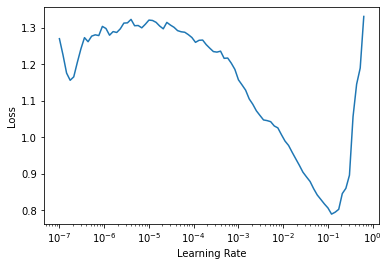

In [117]:
# finding best learning rate
learn.lr_find()

In [126]:
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.447130,0.573170,0.133013,01:35
1,0.260940,0.351683,0.107372,01:35
2,0.159149,0.271141,0.097756,01:34
3,0.121106,0.256611,0.081731,01:35


In [128]:
learn.unfreeze()

SuggestedLRs(lr_min=2.511886486900039e-06, lr_steep=9.12010818865383e-07)

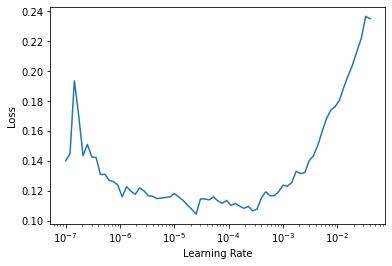

In [121]:
learn.lr_find()

In [129]:
learn.fit_one_cycle(10, lr_max=1.3e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.113823,0.266726,0.084936,01:37
1,0.107356,0.258269,0.078526,01:36
2,0.093804,0.234710,0.076923,01:35
3,0.088610,0.268602,0.094551,01:38
4,0.084174,0.234088,0.076923,01:38
5,0.079003,0.244796,0.081731,01:38
6,0.064989,0.255061,0.091346,01:38
7,0.064860,0.219599,0.070513,01:37
8,0.070464,0.210941,0.070513,01:36
9,0.062105,0.235377,0.080128,01:36


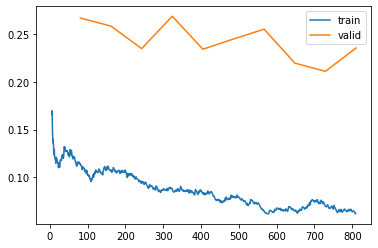

In [130]:
learn.recorder.plot_loss()

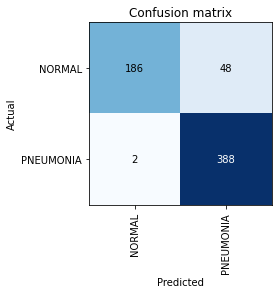

In [131]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [99]:
# save the trained model
#learn.export(project_path/'drchex_resize460_aug224-0.75_unfreeze.pkl')

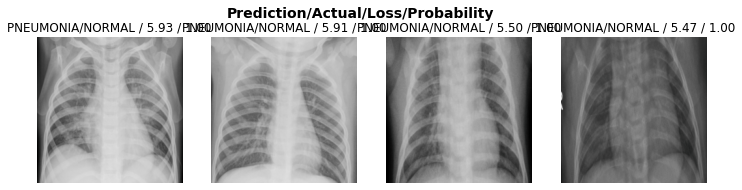

In [132]:
# viewing top xrays that the model reconized them confidently wrong
interp.plot_top_losses(4, nrows=1)

## Load model for inference

In [133]:
learn_inf = load_learner(project_path/'drchex_resize460_aug224-0.75_unfreeze.pkl')

In [134]:
# check model performance (prediction) on validation set
val_set = get_image_files(xrays_path/'val')

for item in val_set:
  print(item.parent.name, ' -> ', learn.predict(item))

PNEUMONIA  ->  ('PNEUMONIA', tensor(1), tensor([0.0028, 0.9972]))


PNEUMONIA  ->  ('PNEUMONIA', tensor(1), tensor([0.0075, 0.9925]))


PNEUMONIA  ->  ('PNEUMONIA', tensor(1), tensor([0.0081, 0.9919]))


PNEUMONIA  ->  ('PNEUMONIA', tensor(1), tensor([0.0013, 0.9987]))


PNEUMONIA  ->  ('PNEUMONIA', tensor(1), tensor([0.0107, 0.9893]))


PNEUMONIA  ->  ('PNEUMONIA', tensor(1), tensor([8.8058e-04, 9.9912e-01]))


PNEUMONIA  ->  ('PNEUMONIA', tensor(1), tensor([0.0026, 0.9974]))


PNEUMONIA  ->  ('PNEUMONIA', tensor(1), tensor([0.0076, 0.9924]))


NORMAL  ->  ('NORMAL', tensor(0), tensor([0.6381, 0.3619]))


NORMAL  ->  ('PNEUMONIA', tensor(1), tensor([0.0127, 0.9873]))


NORMAL  ->  ('NORMAL', tensor(0), tensor([0.9026, 0.0974]))


NORMAL  ->  ('NORMAL', tensor(0), tensor([0.9873, 0.0127]))


NORMAL  ->  ('NORMAL', tensor(0), tensor([0.9916, 0.0084]))


NORMAL  ->  ('PNEUMONIA', tensor(1), tensor([0.2864, 0.7136]))


NORMAL  ->  ('NORMAL', tensor(0), tensor([0.6786, 0.3214]))


NORMAL  ->  ('PNEUMONIA', tensor(1), tensor([0.1825, 0.8175]))


The model is performing very well on predicting PNEUMONIA cases (100%) and some wrong predictions over NORMAL cases.  

To automate infrence and try some xrays from internet:

In [142]:
def on_click_diagnose(change):
  """
  """
  xray = PILImage.create(btn_upload.data[0])
  img_box.clear_output()
  with img_box: display(xray.to_thumb(256, 256))
  pred, pred_idx, probs = learn_inf.predict(xray)
  lbl_pred.value = f'Prediction : {pred}, Probability : {probs[pred_idx]:.04f}'

In [143]:
# creat widgets for bulding the app
lbl_pred = widgets.Label()
btn_upload = widgets.FileUpload()
img_box = widgets.Output()
btn_run = widgets.Button(description='Diagnose')
btn_run.on_click(on_click_diagnose)

In [147]:
VBox([widgets.Label("Choose a Chest X-Ray"),
      btn_upload,
      btn_run,
      img_box,
      lbl_pred])